In [1]:
!pip install tensorflow tensorflow_datasets

In [2]:
from tensorflow.keras.datasets import mnist

(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

train_images = train_images.reshape((60000, 28, 28, 1))
train_images = train_images.astype("float32") / 255
test_images = test_images.reshape((10000, 28, 28, 1))
test_images = test_images.astype("float32") / 255


11490434/11490434 [==============================] - 0s 0us/step


In [3]:
print(len(train_images[50000:]))
print(len(train_labels[50000:]))

10000
10000


In [4]:
valid_images = train_images[50000:]
valid_labels = train_labels[50000:]

train_images = train_images[:50000]
train_labels = train_labels[:50000]

test_images = test_images
test_labels = test_labels

print(len(train_images))
print(len(valid_images))
print(len(test_images))

50000
10000
10000


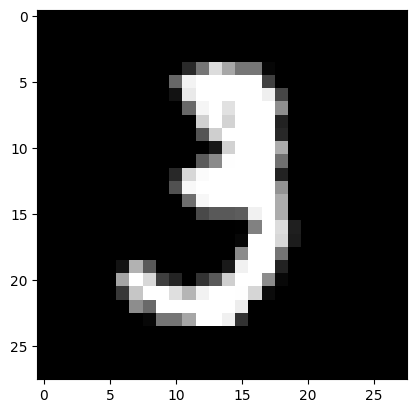

In [5]:
import matplotlib.pyplot as plt

def preview_dataset(image):
    # plot the sample
    fig = plt.figure
    plt.imshow(image, cmap='gray')
    plt.show()

preview_dataset(train_images[10])

In [6]:
import tensorflow as tf

train_dataset = tf.data.Dataset.from_tensor_slices((train_images, train_labels))
valid_dataset = tf.data.Dataset.from_tensor_slices((valid_images, valid_labels))
test_dataset = tf.data.Dataset.from_tensor_slices((test_images, test_labels))

print(train_dataset)
print(valid_dataset)
print(test_dataset)

<_TensorSliceDataset element_spec=(TensorSpec(shape=(28, 28, 1), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.uint8, name=None))>
<_TensorSliceDataset element_spec=(TensorSpec(shape=(28, 28, 1), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.uint8, name=None))>
<_TensorSliceDataset element_spec=(TensorSpec(shape=(28, 28, 1), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.uint8, name=None))>


In [7]:
train_ds = train_dataset.shuffle(1000).batch(128).prefetch(tf.data.experimental.AUTOTUNE)
valid_ds = valid_dataset.shuffle(1000).batch(128).prefetch(tf.data.experimental.AUTOTUNE)
test_ds = test_dataset.shuffle(1000).batch(128).prefetch(tf.data.experimental.AUTOTUNE)

print(train_ds)
print(valid_ds)
print(test_ds)

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 28, 28, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.uint8, name=None))>
<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 28, 28, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.uint8, name=None))>
<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 28, 28, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.uint8, name=None))>


## lr = 1e-4

In [8]:
from tensorflow import keras
from tensorflow.keras import layers

data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),
    ]
)

inputs = keras.Input(shape=(28, 28, 1))
x = data_augmentation(inputs)

x = layers.Rescaling(1./255)(x)
x = layers.Conv2D(filters=32, kernel_size=5, use_bias=False)(inputs)

for size in [32, 64, 128, 256, 512]:
    residual = x

    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    x = layers.SeparableConv2D(size, 3, padding="same", use_bias=False)(x)

    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    x = layers.SeparableConv2D(size, 3, padding="same", use_bias=False)(x)

    x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

    residual = layers.Conv2D(
        size, 1, strides=2, padding="same", use_bias=False)(residual)
    x = layers.add([x, residual])

x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(10, activation="softmax")(x)

model = keras.Model(inputs=inputs, outputs=outputs)

In [9]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.Adam(learning_rate=1e-4),
              metrics=["accuracy"])

callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath = 'xception_50epch',
        save_best_only=True,
        monitor='val_loss'
    )
]
history = model.fit(
    train_ds,
    epochs=50,
    validation_data=valid_ds,
    callbacks=callbacks)

Epoch 1/50
391/391 [==============================] - 35s 41ms/step - loss: 0.7430 - accuracy: 0.7942 - val_loss: 3.2914 - val_accuracy: 0.1064
Epoch 2/50
391/391 [==============================] - 13s 33ms/step - loss: 0.1101 - accuracy: 0.9677 - val_loss: 0.0852 - val_accuracy: 0.9761
Epoch 3/50
391/391 [==============================] - 13s 33ms/step - loss: 0.0672 - accuracy: 0.9796 - val_loss: 0.0586 - val_accuracy: 0.9832
Epoch 4/50
391/391 [==============================] - 13s 32ms/step - loss: 0.0463 - accuracy: 0.9860 - val_loss: 0.0510 - val_accuracy: 0.9845
Epoch 5/50
391/391 [==============================] - 13s 32ms/step - loss: 0.0337 - accuracy: 0.9900 - val_loss: 0.0465 - val_accuracy: 0.9861
Epoch 6/50
391/391 [==============================] - 13s 33ms/step - loss: 0.0239 - accuracy: 0.9933 - val_loss: 0.0458 - val_accuracy: 0.9863
Epoch 7/50
391/391 [==============================] - 13s 33ms/step - loss: 0.0180 - accuracy: 0.9947 - val_loss: 0.0437 - val_accuracy:

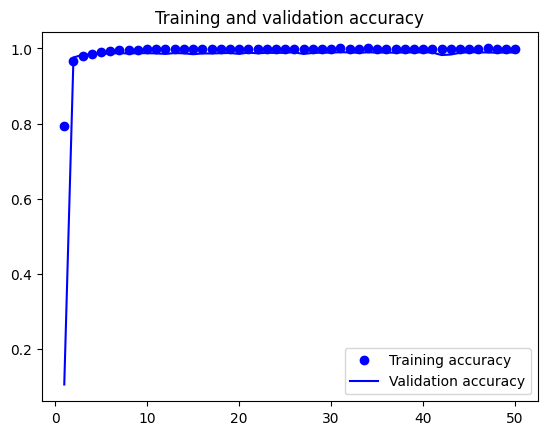

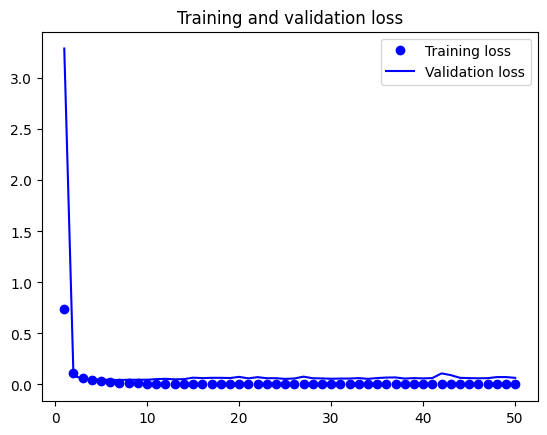

In [10]:
import matplotlib.pyplot as plt

accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, "bo", label="Training accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

79/79 [==============================] - 1s 6ms/step - loss: 0.0361 - accuracy: 0.9880
Evaluation Time: 0.9482111930847168 seconds
Test Accuracy: 0.9879999756813049
Test Loss: 0.036140669137239456


(0.0, 1.987999975681305)

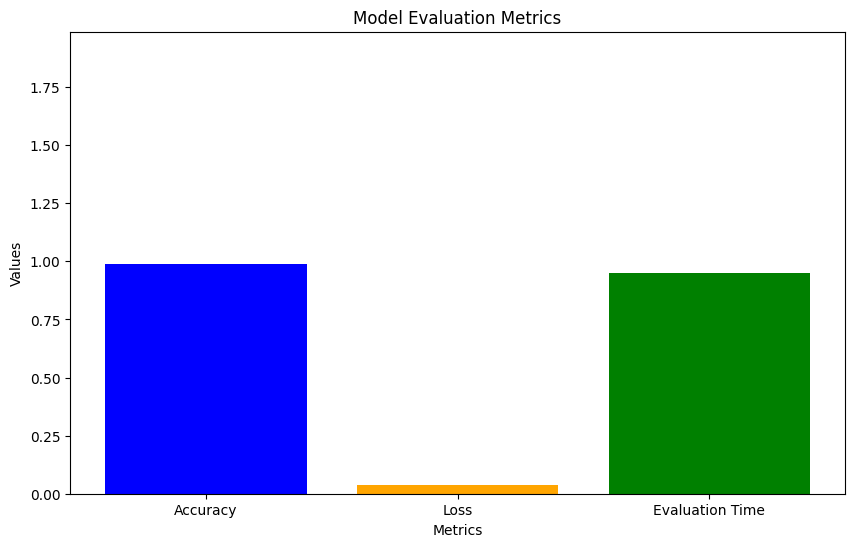

In [16]:
import time
import matplotlib.pyplot as plt
from tensorflow import keras

test_model = keras.models.load_model('xception_50epch')
start_time = time.time()
test_loss, test_acc = test_model.evaluate(test_ds)
end_time = time.time()
eval_time = end_time - start_time

print(f"Evaluation Time: {eval_time} seconds")
print(f"Test Accuracy: {test_acc}")
print(f"Test Loss: {test_loss}")

#그래프 그리기
metrics = ['Accuracy', 'Loss', 'Evaluation Time']
values = [test_acc, test_loss, eval_time]

plt.figure(figsize=(10, 6))
plt.bar(metrics, values, color=['blue', 'orange', 'green'])
plt.xlabel('Metrics')
plt.ylabel('Values')
plt.title('Model Evaluation Metrics')
plt.ylim(0, max(values) + 1)  # Adjust


## le = 1e-5

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers

data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),
    ]
)

inputs = keras.Input(shape=(28, 28, 1))
x = data_augmentation(inputs)

x = layers.Rescaling(1./255)(x)
x = layers.Conv2D(filters=32, kernel_size=5, use_bias=False)(inputs)

for size in [32, 64, 128, 256, 512]:
    residual = x

    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    x = layers.SeparableConv2D(size, 3, padding="same", use_bias=False)(x)

    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    x = layers.SeparableConv2D(size, 3, padding="same", use_bias=False)(x)

    x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

    residual = layers.Conv2D(
        size, 1, strides=2, padding="same", use_bias=False)(residual)
    x = layers.add([x, residual])

x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(10, activation="softmax")(x)

model = keras.Model(inputs=inputs, outputs=outputs)

In [ ]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.Adam(learning_rate=1e-5),
              metrics=["accuracy"])

callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath = 'xception_50epch',
        save_best_only=True,
        monitor='val_loss'
    )
]
history = model.fit(
    train_ds,
    epochs=50,
    validation_data=valid_ds,
    callbacks=callbacks)

Epoch 1/50
391/391 [==============================] - 21s 38ms/step - loss: 2.1701 - accuracy: 0.3186 - val_loss: 2.2960 - val_accuracy: 0.1064
Epoch 2/50
391/391 [==============================] - 13s 34ms/step - loss: 1.7201 - accuracy: 0.6192 - val_loss: 1.4349 - val_accuracy: 0.7608
Epoch 3/50
391/391 [==============================] - 13s 34ms/step - loss: 1.1040 - accuracy: 0.7743 - val_loss: 0.7573 - val_accuracy: 0.8602
Epoch 4/50
391/391 [==============================] - 13s 33ms/step - loss: 0.6520 - accuracy: 0.8654 - val_loss: 0.4452 - val_accuracy: 0.9094
Epoch 5/50
391/391 [==============================] - 13s 34ms/step - loss: 0.4133 - accuracy: 0.9090 - val_loss: 0.2935 - val_accuracy: 0.9349
Epoch 6/50
391/391 [==============================] - 13s 33ms/step - loss: 0.2905 - accuracy: 0.9299 - val_loss: 0.2166 - val_accuracy: 0.9472
Epoch 7/50
391/391 [==============================] - 13s 34ms/step - loss: 0.2257 - accuracy: 0.9418 - val_loss: 0.1747 - val_accuracy:

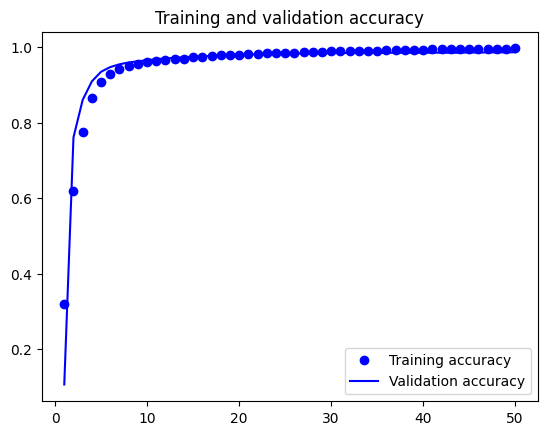

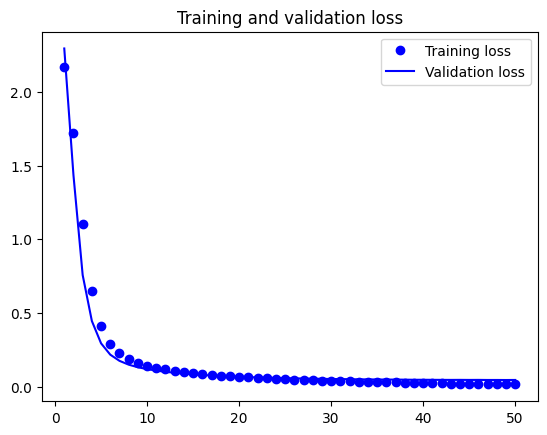

In [ ]:
import matplotlib.pyplot as plt

accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, "bo", label="Training accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

79/79 [==============================] - 1s 6ms/step - loss: 0.0368 - accuracy: 0.9890
Evaluation Time: 0.9363977909088135 seconds
Test Accuracy: 0.9890000224113464
Test Loss: 0.03678738325834274


(0.0, 1.9890000224113464)

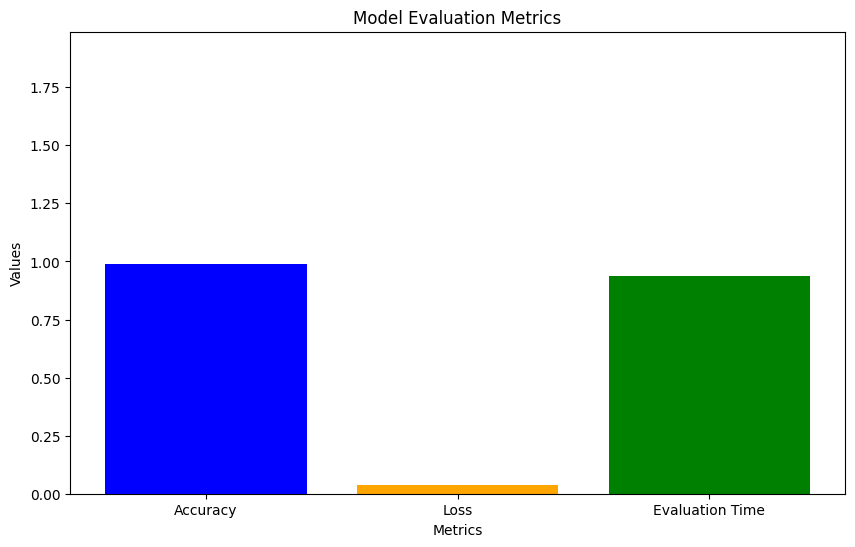

In [ ]:
import time
import matplotlib.pyplot as plt
from tensorflow import keras

test_model = keras.models.load_model('xception_50epch')
start_time = time.time()
test_loss, test_acc = test_model.evaluate(test_ds)
end_time = time.time()
eval_time = end_time - start_time

print(f"Evaluation Time: {eval_time} seconds")
print(f"Test Accuracy: {test_acc}")
print(f"Test Loss: {test_loss}")

#그래프 그리기
metrics = ['Accuracy', 'Loss', 'Evaluation Time']
values = [test_acc, test_loss, eval_time]

plt.figure(figsize=(10, 6))
plt.bar(metrics, values, color=['blue', 'orange', 'green'])
plt.xlabel('Metrics')
plt.ylabel('Values')
plt.title('Model Evaluation Metrics')
plt.ylim(0, max(values) + 1)  # Adjust
